In [10]:
import os
import pandas as pd
import numpy as np

# Specify the folder path
folder_path = 'Dataset/Figure 3/BreathingPattern6/config0001'

# Define file paths
real_file = os.path.join(folder_path, 'config0001_csi_real_log.csv')
imag_file = os.path.join(folder_path, 'config0001_csi_imag_log.csv')
metadata_file = os.path.join(folder_path, 'config0001.csv')

# Load real and imaginary parts of CSI
csi_real = pd.read_csv(real_file, header=None)
csi_imag = pd.read_csv(imag_file, header=None)

# Combine real and imaginary to create complex CSI data
csi_data = csi_real.values + 1j * csi_imag.values

# Load metadata
metadata = pd.read_csv(metadata_file)

# Print summary
print("Data loaded successfully!")
print(f"CSI Data Shape: {csi_data.shape}")
print("Metadata preview:")
print(metadata.head())


Data loaded successfully!
CSI Data Shape: (600, 1026)
Metadata preview:
           Var1   Value
0            mm       1
1           bpm      15
2       msgFreq      10
3  motor_offset  100000
4     attn_left       0


In [11]:
# Hampel filter function
def hampel_filter(data, window_size=5, n_sigmas=3):
    median = np.median(data, axis=0)
    deviation = np.abs(data - median)
    mad = np.median(deviation, axis=0)
    threshold = n_sigmas * mad
    filtered_data = np.where(deviation < threshold, data, median)
    return filtered_data

# Apply Hampel filter to CSI data
csi_data_filtered = hampel_filter(csi_data)
print("Outliers removed successfully!")


Outliers removed successfully!


In [12]:
from scipy.signal import butter, filtfilt

# Butterworth low-pass filter
def butter_lowpass_filter(data, cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data, axis=0)
    return y

# Apply Butterworth filter to remove noise
fs = 10  # Sampling frequency
cutoff = 0.1  # Cutoff frequency
csi_data_smoothed = butter_lowpass_filter(csi_data_filtered.real, cutoff, fs)
print("Noise reduction applied successfully!")


Noise reduction applied successfully!


In [13]:
# Compute Amplitude and Phase
amplitude = np.abs(csi_data_smoothed)
phase = np.angle(csi_data_smoothed)

print("Amplitude and Phase extracted successfully!")
print(f"Amplitude Shape: {amplitude.shape}")
print(f"Phase Shape: {phase.shape}")


Amplitude and Phase extracted successfully!
Amplitude Shape: (600, 1026)
Phase Shape: (600, 1026)


In [14]:
from scipy.fft import fft

# FFT for frequency domain analysis
fft_amplitude = fft(amplitude, axis=0)
fft_magnitude = np.abs(fft_amplitude)

print("FFT spectrum analysis completed successfully!")
print(f"FFT Shape: {fft_magnitude.shape}")


FFT spectrum analysis completed successfully!
FFT Shape: (600, 1026)


In [15]:
import numpy as np

# Calculate frequency bins
fs = 10  # Sampling frequency (Hz)
n = fft_amplitude.shape[0]
freqs = np.fft.fftfreq(n, d=1/fs)

# Find the peak frequency for each subcarrier/link
dominant_frequencies = freqs[np.argmax(fft_magnitude, axis=0)]

# Convert frequency to Breaths Per Minute (BPM)
dominant_bpm = dominant_frequencies * 60  # Convert Hz to BPM

# Print a summary
print("Dominant Frequencies (Hz):")
print(dominant_frequencies[:10])  # Display first 10 frequencies
print("Dominant Breathing Rates (BPM):")
print(dominant_bpm[:10])  # Display first 10 BPM rates


Dominant Frequencies (Hz):
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Dominant Breathing Rates (BPM):
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


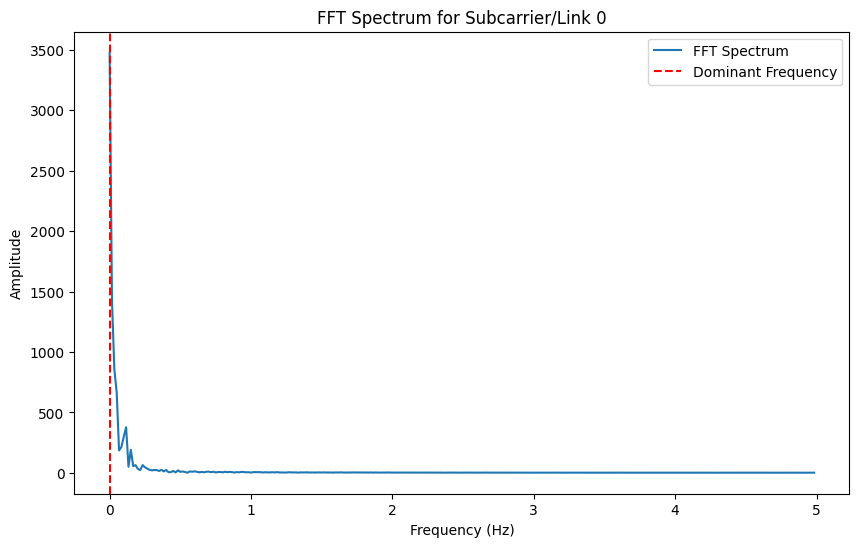

In [16]:
import matplotlib.pyplot as plt

# Choose a subcarrier/link (e.g., 0th index)
index = 0
plt.figure(figsize=(10, 6))
plt.plot(freqs[:n//2], fft_magnitude[:n//2, index], label='FFT Spectrum')
plt.axvline(x=dominant_frequencies[index], color='r', linestyle='--', label='Dominant Frequency')
plt.title(f'FFT Spectrum for Subcarrier/Link {index}')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()


In [17]:
# Calculate the overall estimated breathing rate
estimated_breathing_rate = np.mean(dominant_bpm)
print(f"Estimated Breathing Rate: {estimated_breathing_rate:.2f} BPM")


Estimated Breathing Rate: 0.00 BPM


In [23]:
import os
import pandas as pd
import numpy as np

# Function to load CSI data and metadata
# Function to load CSI data and metadata
def load_csi_dataset(base_path):
    data = []
    labels = []
    for figure in os.listdir(base_path):
        figure_path = os.path.join(base_path, figure)
        if not os.path.isdir(figure_path):
            continue
        for pattern in os.listdir(figure_path):
            pattern_path = os.path.join(figure_path, pattern)
            config_path = os.path.join(pattern_path, "config0001")
            if not os.path.isdir(config_path):
                continue
            # Load real and imaginary CSI
            real_file = os.path.join(config_path, "config0001_csi_real_log.csv")
            imag_file = os.path.join(config_path, "config0001_csi_imag_log.csv")
            metadata_file = os.path.join(config_path, "config0001.csv")
            
            csi_real = pd.read_csv(real_file, header=None).values
            csi_imag = pd.read_csv(imag_file, header=None).values
            metadata = pd.read_csv(metadata_file)
            
            # Combine into complex CSI matrix
            csi_data = csi_real + 1j * csi_imag
            
            # Extract bpm
            bpm_row = metadata[metadata['Var1'] == 'bpm']
            bpm = float(bpm_row['Value'].values[0])  # Convert to float
            
            data.append(csi_data)
            labels.append(bpm)
    return np.array(data), np.array(labels)

base_path = 'Dataset'  # Replace with your dataset path
# Reload dataset
csi_data, labels = load_csi_dataset(base_path)
print(f"Loaded CSI Dataset: {csi_data.shape}")
print(f"Labels Shape: {labels.shape}")
print(f"Sample Labels: {labels[:50]}")

# Load dataset

# csi_data, labels = load_csi_dataset(base_path)
# print(f"Loaded CSI Dataset: {csi_data.shape}")
# print(f"Labels Shape: {labels.shape}")
# print(labels[:5])


Loaded CSI Dataset: (82, 600, 1026)
Labels Shape: (82,)
Sample Labels: [15. 15. 15. 15. 18. 15. 15. 18. 18. 18. 25. 22. 25. 22. 28. 28.  6.  6.
 25. 25. 19. 19. 17. 23. 13. 21.  4. 19. 27.  9. 24. 14. 16. 29. 30. 11.
 26. 15. 12. 28.  8. 22. 25.  6.  5.  3. 20.  7. 10. 18.]


In [ ]:
# Extract bpm from the metadata
bpm_row = metadata[metadata['Var1'] == 'bpm']
bpm = bpm_row['Value'].values[0]  # Extract the bpm value
print(f"Extracted BPM: {bpm}")


In [ ]:
# Preprocessing and Feature Extraction
from scipy.signal import butter, filtfilt

def preprocess_and_extract_features(csi_data):
    # Initialize containers
    amplitudes = []
    phases = []
    for sample in csi_data:
        # Calculate amplitude and phase
        amplitude = np.abs(sample)
        phase = np.angle(sample)
        
        # Smoothen amplitude using Butterworth filter
        fs = 10  # Sampling frequency
        cutoff = 0.1  # Cutoff frequency
        b, a = butter(5, cutoff / (0.5 * fs), btype='low', analog=False)
        amplitude_smoothed = filtfilt(b, a, amplitude, axis=0)
        
        amplitudes.append(amplitude_smoothed)
        phases.append(phase)
    
    return np.array(amplitudes), np.array(phases)

amplitudes, phases = preprocess_and_extract_features(csi_data)
print(f"Amplitudes Shape: {amplitudes.shape}")
print(f"Phases Shape: {phases.shape}")


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout

# Build BiLSTM model
def build_bilstm_model(input_shape):
    model = Sequential([
        Bidirectional(LSTM(64, return_sequences=True), input_shape=input_shape),
        Dropout(0.3),
        Bidirectional(LSTM(32)),
        Dropout(0.3),
        Dense(1, activation='linear')  # Use 'softmax' for classification
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])  # Adjust for classification if needed
    return model

# Input shape: (time_steps, features)
time_steps = amplitudes.shape[1]
features = amplitudes.shape[2]
model = build_bilstm_model((time_steps, features))
model.summary()


In [ ]:
# Split data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(amplitudes, labels, test_size=0.2, random_state=42)

# Train model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32)


In [ ]:
# Evaluate the model on the test set
loss, mae = model.evaluate(X_test, y_test, verbose=1)

print(f"Test Loss (MSE): {loss}")
print(f"Test MAE: {mae}")


In [ ]:
# Predict breathing rates
y_pred = model.predict(X_test)

# Display some predictions vs ground truth
for i in range(1):
    print(f"Ground Truth: {y_test[i]:.2f} BPM, Predicted: {y_pred[i][0]:.2f} BPM")


In [ ]:
import matplotlib.pyplot as plt

# Plot predicted vs true values
plt.figure(figsize=(10, 6))
plt.plot(y_test, label="True Values (BPM)", marker='o')
plt.plot(y_pred, label="Predicted Values (BPM)", marker='x')
plt.title("Breathing Rate: True vs Predicted")
plt.xlabel("Sample Index")
plt.ylabel("Breathing Rate (BPM)")
plt.legend()
plt.grid()
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

# Plot histogram of prediction errors
errors = y_pred.flatten() - y_test
plt.figure(figsize=(8, 5))
plt.hist(errors, bins=20, edgecolor='k')
plt.title("Histogram of Prediction Errors")
plt.xlabel("Prediction Error (BPM)")
plt.ylabel("Frequency")
plt.grid()
plt.show()


In [ ]:
# Select a single sample for prediction
sample = X_test[0:1]  # Take the first sample
true_value = y_test[0]

# Predict the breathing rate
predicted_value = model.predict(sample)[0][0]
print(f"Real-Time Prediction:")
print(f"True Breathing Rate: {true_value:.2f} BPM")
print(f"Predicted Breathing Rate: {predicted_value:.2f} BPM")
